In [ ]:
import torch
import torch.optim as optim
from torch.autograd import Variable

# cuda settings
USE_CUDA = torch.cuda.is_available()

def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

print('Using CUDA:',USE_CUDA)

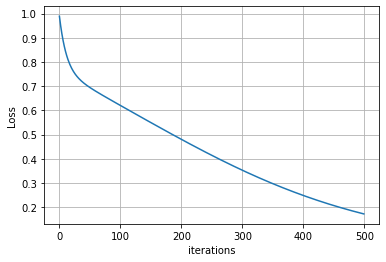

In [2]:
import numpy as np
from matplotlib import pyplot as plt
inputs = np.array([[-1,0],[0,1],[4,4],[2,3]])
targets = np.array([-1,-1,+1,+1])
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
H, D_out = 2, 1
x = toTensor(inputs)
y = toTensor(targets)
N,D_in = x.shape
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
)
model=cuda(model)
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
L = []

for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x).flatten()
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    L.append(loss.item())
    # Zero the gradients before running the backward pass.
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    model.zero_grad()
    loss.backward()
    optimizer.step()
plt.plot(L);plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm.notebook import tqdm
USE_CUDA = torch.cuda.is_available()
from torch.autograd import Variable

def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    vec = v.clone().detach()
    return cuda(Variable(vec).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

# Hyper Parameters
input_size = 784 #number of features
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = cuda(Net(input_size, hidden_size, num_classes))

In [79]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = [] # loss history

# Train the Model
model.train() #set the mode to training
for epoch in range(num_epochs):
    for i, (images, labels) in tqdm(enumerate(train_loader)):  #pick a batch
        # Convert torch tensor to Variable

        images = toTensor(images.view(-1, 28*28))
        labels = toTensor(labels,dtype=torch.long)

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = model(images)
        loss = criterion(outputs, labels)
        L.append(loss.item())
        loss.backward()
        optimizer.step()

plt.plot(L);plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()

0it [00:00, ?it/s]

RuntimeError: shape '[-1, 784]' is invalid for input of size 320

In [10]:

# Test the Model
model.eval() #set the mode to evaluation
correct = 0
total = 0
for images, labels in test_loader:
    images = toTensor(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (toNumpy(predicted) == toNumpy(labels)).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Model
#torch.save(model.state_dict(), 'model.pkl')

<ipython-input-7-a764a003a643>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))


Accuracy of the network on the 10000 test images: 97 %


In [328]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    reading the testset and return a dictionary with: ID -> sentiment
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}  # init the dictionary
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]
            id_gts[tweetid] = gt

    return id_gts

def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1
        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1
        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1
        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)
    return semevalmacrof1


In [70]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

class tweet_dataset(Dataset):
    def __init__(self, dataset_pkl):
        # load the preprocessed (tokenized) data from pickle file 'dataset_pkl'
        with open(dataset_pkl, 'rb') as inp_file:
            temp = pickle.load(inp_file)
            [xs, ys] = temp
            xs = torch.from_numpy(xs)
            ys = torch.from_numpy(ys) + 1   # adding 1 so that the classes are 0-negative, 1-neutral, 2-positive
            self.x = toTensor(xs, dtype=torch.long, requires_grad=False)
            self.y = toTensor(ys, dtype=torch.long, requires_grad=False)
            self.n_samples = len(ys)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_samples




# temp = tweet_dataset("small_train.pkl")
# dataloader = DataLoader(dataset = temp, batch_size=4, shuffle=True, drop_last=True)
# dataiter = iter(dataloader)
# data = next(dataiter)


# dummy training
    # num_epochs = 2
    # num_samples = len(temp)
    # num_iterations = num_samples // 4
    # print(num_samples, num_iterations)
    #
    # for epoch in range(num_epochs):
    #     for i, (inputs, labels) in enumerate(dataloader):
    #         # forward
    #         # backward
    #         if i%10==0:
    #             print(f"epoch {epoch+1}/{num_epochs},iteration {i+1}/{num_iterations},inputs {inputs.shape},labs {labels.shape}")

# with open("preprocessing-glove.pkl", 'rb') as inp_file:
#     temp_dicts = pickle.load(inp_file)
#     [_,_,_,_,_, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev] = temp_dicts
# with open("preprocessing-glove.pkl", 'rb') as inp_file:
#     temp_dicts = pickle.load(inp_file)
#     [y_train, y_test1, y_test2, y_test3, y_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev] = temp_dicts


  0%|          | 0/2 [00:00<?, ?it/s]

hidden_size:[64, 50]  n_layers:1  n_classes:3  n_epochs:20  batch_size:128  learning_rate:0.001  
  Train loss: 	 0.932 		Validation loss: 0.840  	Validation acc:  0.601 


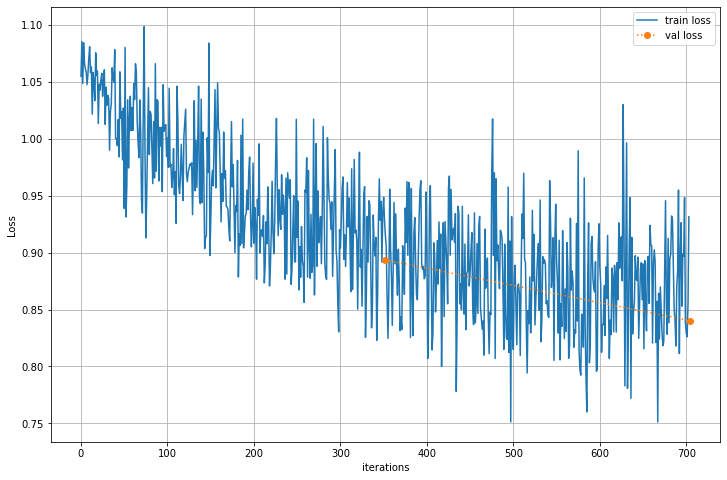

In [364]:
# sample RNN code
import torch.nn as nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# setup a random seed for reproducible results
def random_seed_setup(seed):
    torch.manual_seed(seed) #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True




device = torch.device('cpu')                        # setting up the device
random_seed_setup(123)                              # setting up the seed
train_dataset = tweet_dataset("xy_train.pkl")    # loading data
dev_dataset = tweet_dataset("xy_dev.pkl")
test_dataset = tweet_dataset("xy_test1.pkl")

# Hyperparameters
input_size = 100
seq_len = 32
hidden_size = 64
n_layers = 1
n_classes = 3
n_epochs = 100
batch_size = 16
learning_rate = 0.0001
HYPER = {'hidden_size': [64,50],'n_layers': 1,'n_classes': 3,'n_epochs': 20,'batch_size': 128,'learning_rate': 0.001}

# data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_classes, embedding_matrix_file="embeddings.pkl"):
        super(RNN, self).__init__()

        # load preprocessed embedding matrix
        with open(embedding_matrix_file, 'rb') as inp_file:
            temp = pickle.load(inp_file)
            [embedding_matrix, word2ID, embedding_dict] = temp
            embedding_matrix = torch.from_numpy(embedding_matrix)


        n_embeddings, embedding_dim = embedding_matrix.size()  # (5000, 100) ~ (n_vocab, glove_dim)
        embedding_layer = nn.Embedding(n_embeddings, embedding_dim)
        embedding_layer.load_state_dict({'weight': embedding_matrix})
        embedding_layer.weight.requires_grad = False

        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = embedding_layer
        self.n_embeddings = n_embeddings
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)  #  x: (batch_size, seq, input_size)
        self.fc1 = nn.Linear(hidden_size, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, n_classes)  # classification layer

        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x_batch):
        init_weights = torch.rand(self.n_layers, x_batch.size(0), self.hidden_size).to(device)
        init_cell = torch.rand(self.n_layers, x_batch.size(0), self.hidden_size).to(device)

        x_to_glove = self.embedding(x_batch)
        out, _ = self.lstm(x_to_glove, (init_weights,init_cell))
            # (10, 32, 60) ~ (batch_size, seq, hidden_dim)
        out = out[:,-1,:]  # take only the last time step in the sequence
            # (10, 60) ~ (batch_size, hidden_dim)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = RNN(input_size, hidden_size, n_layers, n_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = []            # training loss history
L_validation = [] # validation loss history
i_val = []        # validation indexes

# Train the model
n_total_steps = len(train_loader)
for epoch in tqdm(range(n_epochs)):
    for i, (xs, ys) in enumerate(train_loader):
        # originally  (100, 32) ~ (samples, max_len_seq)
        # after embedding: (100, 32, 100) ~ (samples, seqs, glove_dim)

        xs = xs.to(device)  # xs will be (10, 32) ~ (batch, seq_len)
        ys = ys.to(device)

        # Forward pass
        outputs = model(xs)
        loss = criterion(outputs, ys)
        L.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if (i+1) % 10 == 0:
        #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')

    # do the validation error analysis
    with torch.no_grad():
        ys_true, ys_pred, L_val = [], [], []
        for  j, (xs, ys) in enumerate(dev_loader):
            preds = model(xs)
            loss = criterion(preds, ys)
            L_val.append(loss)
            ys_true.append(ys)
            ys_pred.append(preds.argmax(dim=-1))
        ys_true = torch.cat(ys_true)
        ys_pred = torch.cat(ys_pred)
        mean_val_loss = torch.tensor(L_val).mean()
        val_accuracy = accuracy_score(ys_true.detach().numpy(), ys_pred.detach().numpy())
        #print("Validation loss: {:.3f}".format(mean_val_loss))
        #print("Validation accu: {:.3f}".format(val_accuracy))
        L_validation.append(mean_val_loss)  # append the validation loss vector
        i_val.append((epoch + 1) * (i + 1))             # record the iteration number for plotting

# reporting the train and validation performance
[print(f"{p}:{n}  " , end='' ) for (p,n) in HYPER.items()]; print('')
print(f"  Train loss: \t {L[-1]:.3f} \t\tValidation loss: {L_validation[-1]:.3f}  \tValidation acc:  {val_accuracy:.3f} ")
plt.figure(figsize=(12,8)); plt.plot(L, label="train loss");plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()
plt.plot(i_val, L_validation, 'o:', label="val loss"); plt.legend(); plt.show()

hidden_size:64  n_layers:1  n_classes:3  n_epochs:20  batch_size:128  learning_rate:0.001  
  Train loss: 	 0.571 		Validation loss: 0.804  	Validation acc:  0.633 


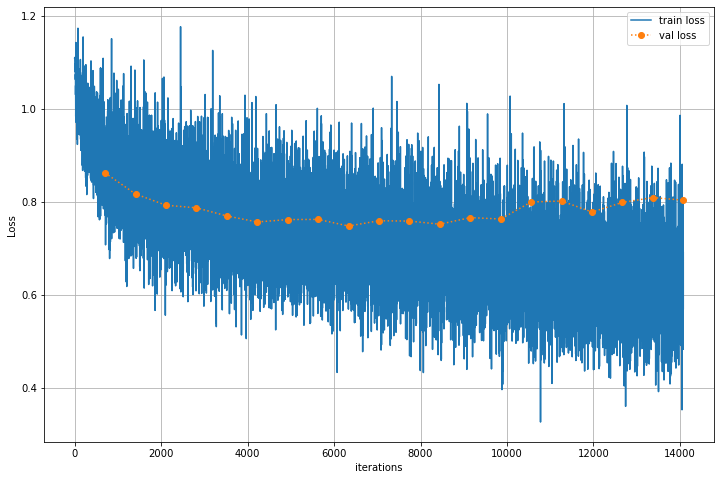

In [362]:
# reporting the train and validation performance
[print(f"{p}:{n}  " , end='' ) for (p,n) in HYPER.items()]; print('')
print(f"  Train loss: \t {L[-1]:.3f} \t\tValidation loss: {L_validation[-1]:.3f}  \tValidation acc:  {val_accuracy:.3f} ")
plt.figure(figsize=(12,8)); plt.plot(L, label="train loss");plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()
plt.plot(i_val, L_validation, 'o:', label="val loss"); plt.legend(); plt.show()

In [331]:
# test sets validation
from sklearn.metrics import confusion_matrix

def sent2num(sent):
    if sent == 'negative':
        return -1
    if sent == 'neutral':
        return 0
    if sent == 'positive':
        return 1

def num2sent(num):
    if num == -1:
        return 'negative'
    if num == 0:
        return 'neutral'
    if num == 1:
        return 'positive'

with open("preprocessing-sent-ID.pkl", 'rb') as inp_file:
    [y_train, y_test1, y_test2, y_test3, y_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev] = pickle.load(inp_file)
    ID_test1 = list(IDs_test1.values())
with open('xy_test1.pkl', 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [xs, ys] = temp
    xs = torch.from_numpy(xs)
    ys = torch.from_numpy(ys) + 1   # adding 1 so that the classes are 0-negative, 1-neutral, 2-positive
    xs = toTensor(xs, dtype=torch.long, requires_grad=False)
    ys = toTensor(ys, dtype=torch.long, requires_grad=False)


# xs = xs.reshape(1, 32)
print(xs.size())
#y = ys.reshape(1)
print('->>>',ys.size())

with torch.no_grad():
    pred = model(xs)
    print(pred.size())
    l = criterion(pred, ys)
    print(l)
    y_pred = pred.argmax(dim=-1)
    print("pred:", y_pred)


# F1 score:
y_pred_numeric = y_pred.detach().numpy()-1
test_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test1, test_pred))
s1 = evaluate(pred_dict, '../semeval-tweets/twitter-test1.txt', classifier="LSTM0")  # best score 0.435
print('F1:', s1)

conf = confusion_matrix(ys.detach().numpy(), y_pred.detach().numpy())
print('  -1   0   1')
print(conf)

torch.Size([3531, 32])
->>> torch.Size([3531])
torch.Size([3531, 3])
tensor(0.8170)
pred: tensor([1, 1, 2,  ..., 1, 1, 1])
../semeval-tweets/twitter-test1.txt (LSTM0): 0.535
F1: 0.5346223871807755
  -1   0   1
[[ 162  333   62]
 [  37 1245  222]
 [  25  592  853]]


In [324]:
IDs_test1[0]

'163361196206957578'